* Prediction

In [1]:
import keras, os, pickle, logging, datetime, time
import tensorflow as tf
import numpy as np
from gensim.models import Word2Vec
from keras.layers import Embedding, LSTM, GRU, Dropout, Dense, Activation, Bidirectional
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, precision_score, recall_score
from argparse import ArgumentParser

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # ignore tensorflow warning
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # to use gpu
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config) # let keras use only required VRAM

model_name = 'full_4c_cb_05'
BATCH_SIZE = 128

logging.basicConfig(level=logging.DEBUG,
                    format="%(asctime)s %(message)s",
                    datefmt='%Y-%m-%d %H:%M:%S',
                    handlers=[logging.FileHandler('./log/train_full_4c_cb.log', 'a', encoding='utf-8')])

logging.debug('===== Start =====')
start_time = time.time()

with open('./pkl/x_train.pkl', 'rb') as f:
    x_train = pickle.load(f)
with open('./pkl/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
with open('./pkl/x_test.pkl', 'rb') as f:
    x_test = pickle.load(f)
with open('./pkl/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)
with open('./pkl/embedding_matrix.pkl', 'rb') as f:
    embedding_matrix = pickle.load(f)
wv_model = Word2Vec.load('./data/fact_w2v_cbow.model')

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
### Model structure
y_train_act = [np.where(y==1)[0][0] for y in y_train]
# class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train_act), y_train_act)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.005, verbose=1, mode='auto', restore_best_weights=True)

model = Sequential()
model.add(Embedding(len(wv_model.wv.vocab)+1, 
                    wv_model.vector_size, 
                    input_length=x_train.shape[1], 
                    weights=[embedding_matrix], 
                    trainable=False))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.2))
model.add(Dense(units=y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train
hist = model.fit(x_train, y_train, validation_split=0.33, 
                 batch_size=BATCH_SIZE, 
                 epochs=60, 
                 callbacks=[early_stopping])
model.save('./model/' + model_name + '.h5')
with open('./model/' + model_name + '_hist.pkl', 'wb') as f:
    pickle.dump(hist, f)

### Evaluation
loss, acc = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
logging.debug('')
logging.debug('%s' % model_name)
logging.debug('Test loss: %.3f, accuracy: %.3f' % (loss, acc))

y_test_act = [np.where(r==1)[0][0] for r in y_test]
y_test_act = np.array(y_test_act)
predictions = model.predict_classes(x_test) 
f1 = f1_score(y_test_act, predictions, average='macro', labels=np.unique(predictions))
precision = precision_score(y_test_act, predictions, average='macro', labels=np.unique(predictions))
recall = recall_score(y_test_act, predictions, average='macro', labels=np.unique(predictions))
logging.debug('f1: %.3f, precision: %.3f, recall: %.3f' %(f1, precision, recall))

time = str(datetime.timedelta(seconds=time.time() - start_time)).split(':')
exe_t = '=== Execution time: ' + time[0] + 'h ' + time[1] + 'min ' + str(round(float(time[2]), 2)) + 's ===\n\n'
logging.debug(exe_t)

Train on 5767 samples, validate on 2841 samples
Epoch 1/60
5767/5767 [==============================] - 176s 31ms/step - loss: 1.0612 - acc: 0.5450 - val_loss: 1.0271 - val_acc: 0.5509
Epoch 2/60
5767/5767 [==============================] - 139s 24ms/step - loss: 1.0233 - acc: 0.5535 - val_loss: 1.0130 - val_acc: 0.5488
Epoch 3/60
5767/5767 [==============================] - 139s 24ms/step - loss: 1.0112 - acc: 0.5554 - val_loss: 1.0292 - val_acc: 0.5516
Epoch 4/60
5767/5767 [==============================] - 144s 25ms/step - loss: 1.0152 - acc: 0.5530 - val_loss: 1.0027 - val_acc: 0.5604
Epoch 5/60
5767/5767 [==============================] - 145s 25ms/step - loss: 0.9774 - acc: 0.5700 - val_loss: 0.9448 - val_acc: 0.5780
Epoch 6/60
5767/5767 [==============================] - 145s 25ms/step - loss: 0.9516 - acc: 0.5781 - val_loss: 0.9682 - val_acc: 0.5699
Epoch 7/60
5767/5767 [==============================] - 159s 28ms/step - loss: 0.9275 - acc: 0.6007 - val_loss: 0.9964 - val_acc: 

* Evaluating

In [3]:
def plot_model(hist):
    history = pd.DataFrame(hist.history)

    plt.figure(figsize=(18,4))
    plt.subplot(121)
    plt.title('Loss')
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.legend(loc='upper right')
    plt.grid()

    plt.subplot(122)
    plt.title('Accuracy')
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.legend(loc='upper right')
    plt.grid()
    plt.show()
    
def macro_score(y_act, predictions):
    f1 = f1_score(y_act, predictions, average='macro', labels=np.unique(predictions))
    precision = precision_score(y_act, predictions, average='macro', labels=np.unique(predictions))
    recall = recall_score(y_act, predictions, average='macro', labels=np.unique(predictions))
    return f1, precision, recall

In [1]:
%matplotlib inline

import pickle, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import load_model
from sklearn.metrics import f1_score, precision_score, recall_score

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # ignore tensorflow warning
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # to use gpu
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config) # let keras use only required VRAM

model_name = 'full_4c_sg_05'
BATCH_SIZE = 128

model = load_model('./model/' + model_name + '.h5')
with open('./model/' + model_name + '_hist.pkl', 'rb') as f:
    hist = pickle.load(f)
with open('./pkl/x_test.pkl', 'rb') as f:
    x_test = pickle.load(f)
with open('./pkl/y_test.pkl', 'rb') as f:
    y_test = pickle.load(f)
with open('./pkl/y_test_act.pkl', 'rb') as f:
    y_act = pickle.load(f)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

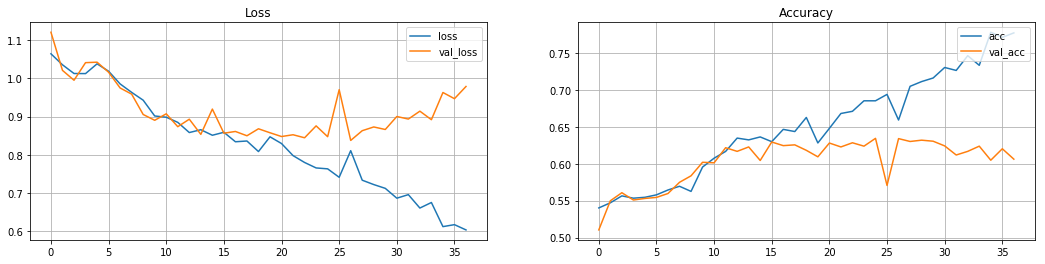

3690/3690 [==============================] - 13s 4ms/step
full_4c_sg_05
Test loss: 0.849, accuracy: 0.650

f1: 0.440, precision: 0.482, recall: 0.430


預測值,0,1,2,3,All
實際值,,,,,
0,1554,244,1,109,1908
1,411,666,0,10,1087
2,34,44,0,1,79
3,419,17,0,180,616
All,2418,971,1,300,3690


In [11]:
plot_model(hist)

loss, acc = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print(model_name)
print("Test loss: %.3f, accuracy: %.3f\n" % (loss, acc))

predictions = model.predict_classes(x_test) 
cf_matrix = pd.crosstab(y_act, predictions, rownames=['實際值'], colnames=['預測值'], margins=True)

f1, precision, recall = macro_score(y_act, predictions)
print('f1: %.3f, precision: %.3f, recall: %.3f' %(f1, precision, recall))
cf_matrix

In [6]:
from collections import Counter
with open('./pkl/4class/y_train.pkl', 'rb') as f:
    y_train = pickle.load(f)
y_train_act = [np.where(y==1)[0][0] for y in y_train]
Counter(y_train_act)

Counter({0: 4529, 1: 2530, 2: 169, 3: 1380})

In [4]:
# # """Show the model structure as a picture"""
# from keras.utils import plot_model
# plot_model(
#     model, 
#     to_file='model.png', 
#     show_shapes=True, 
#     show_layer_names=False, 
#     rankdir='LR')